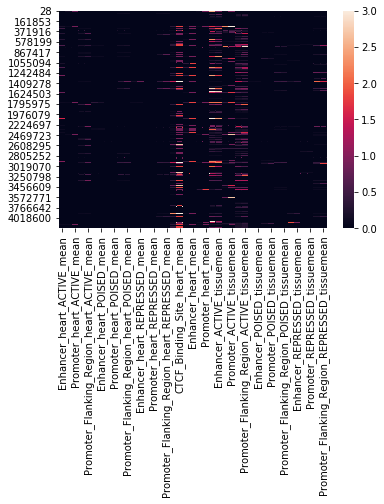

In [1]:
# A notebook to play around with the biomart datasets:
import pybiomart
import os
import pickle
import pandas as pd
import seaborn as sns
import pybedtools
import pybedtools.featurefuncs as featurefuncs
import umap
import numpy as np
from sklearn.preprocessing import maxabs_scale

activity_var_df = pd.read_pickle("data/activity_variances.pkl")
ctcf_var_df = pd.read_pickle("data/iap_variances.pkl")
tissue_var_df = pd.read_pickle("data/activity_tissue_variances.pkl")
concat_list = [activity_var_df.sort_index(),
               ctcf_var_df.iloc[:, 7:].sort_index(),
               tissue_var_df.iloc[:, 7:].sort_index()]
total_df = pd.concat(concat_list, axis=1)

sns.heatmap(total_df.iloc[:, 8:], vmin=0, vmax=3)

In [ ]:
total_df["integer_encodings"] = total_df["val_result"].copy()
total_df["val_result"] = total_df["val_result"].replace("-1", "Untested")

total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Untested", -1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("True ME", 1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("False-positive", 2)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Tissue-specific", 3)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace(3, 1)
cols = []
cols = total_df.columns.tolist()
cols = cols[:7] + [cols[-1]] + cols[7:-1]
total_df = total_df.loc[:, cols]

In [33]:
# Generating validation dataframe for model training:
val_df = total_df[total_df.val_result != "Untested"].copy()
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MaxAbsScaler

# Selecting high variance features:
selector = VarianceThreshold(threshold=0)
selector.fit(total_df.iloc[:, 8:])
support = selector.get_support(indices=True)

# Extracting high variance & normalising:
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]
print(kbest_total.shape)
kbest_val = val_df.iloc[:, 8:][val_df.iloc[:, 8:].columns[support]]

transformer = MaxAbsScaler().fit(kbest_total)
kbest_total_abs = transformer.transform(kbest_total)
kbest_val_abs = transformer.transform(kbest_val)

(8059, 42)


In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(kbest_total_abs)
embedding_total = pca.transform(kbest_total_abs)
embedding_val = pca.transform(kbest_val_abs)

In [35]:
import matplotlib.pyplot as plt
import matplotlib
hue_order = ["Untested", "Tissue-specific", "True ME", "False-positive"]

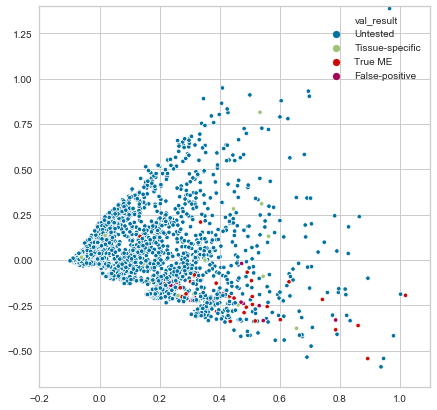

In [36]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

ax = sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1],
                     hue=total_df["val_result"], hue_order=hue_order, s=20, marker='o')
ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
plt.savefig("plots/pca_total.png", dpi=200)
plt.savefig("plots/pca_total.pdf")

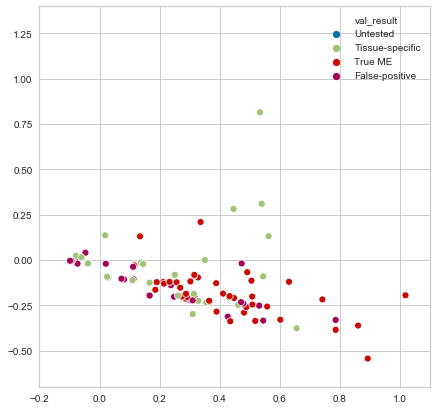

In [37]:
matplotlib.rcParams['figure.figsize'] = [7, 7]
val_df.loc[:, "pca_x"] = embedding_val[:, 0]
val_df.loc[:, "pca_y"] = embedding_val[:, 1]

ax = sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["val_result"], hue_order=hue_order)
ax.set(xlim=(-0.2, 1.1), ylim=(-0.7, 1.4))
plt.savefig("plots/pca_val.png", dpi=200)
plt.savefig("plots/pca_val.pdf")

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(kbest_total_abs)
total_category_labels = pd.Series(kmeans.labels_)
total_category_labels.index = total_df["element_id"].astype(int).to_list()

sorted_total_df = total_df.iloc[:, 0:7].copy(deep=True)
sorted_total_df["cluster_assignments"] = total_category_labels

hue_order = ["A", "B", "C", "D", "E"]

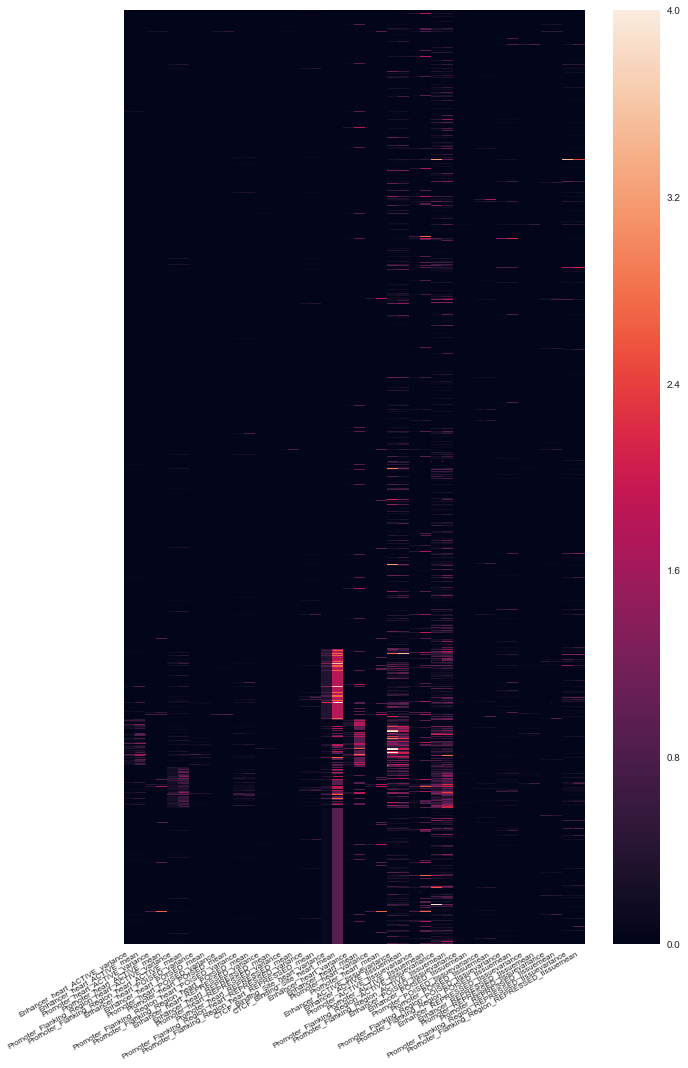

In [39]:
matplotlib.rcParams['figure.figsize'] = [10, 15]

kbest_total["cluster_assignments"] = sorted_total_df["cluster_assignments"]
kbest_total = kbest_total.sort_values(by=["cluster_assignments"])
ax = sns.heatmap(kbest_total.iloc[:, :-1], vmin=0, vmax=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=8, horizontalalignment='right')
ax.set_yticklabels([])
plt.tight_layout()
plt.savefig("plots/kcluster_heatmap.png", dpi=200)
plt.savefig("plots/kcluster_heatmap.pdf")

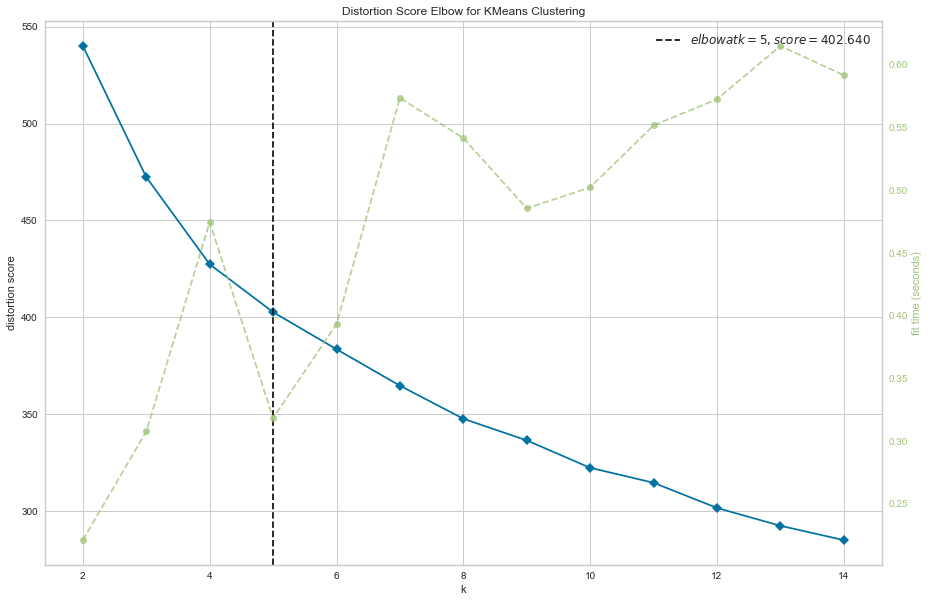

/Users/omar/Documents/GitHub/VMIAP/venv/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x135061650>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [45]:
from yellowbrick.cluster.elbow import kelbow_visualizer
matplotlib.rcParams['figure.figsize'] = [15, 10]

kelbow_visualizer(KMeans(random_state=0), kbest_total_abs, k=(2,15))

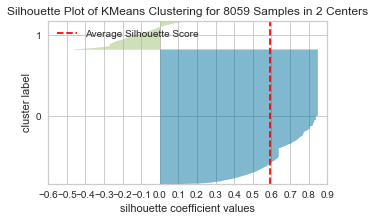

0.5894900226851214

In [46]:
matplotlib.rcParams['figure.figsize'] = [5, 3]

from yellowbrick.cluster import silhouette_visualizer

silhouette_visualizer(KMeans(2, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

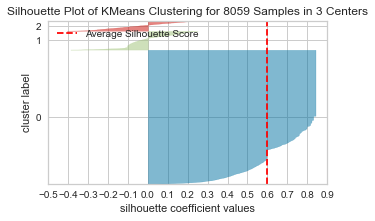

0.5966833547252753

In [47]:
silhouette_visualizer(KMeans(3, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

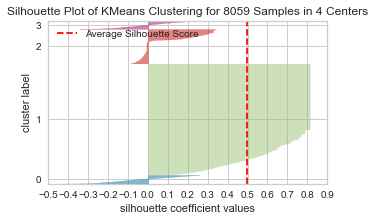

0.49682940873079184

In [48]:
silhouette_visualizer(KMeans(4, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

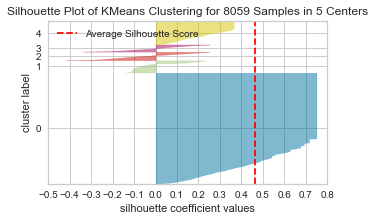

0.4616453943727721

In [49]:
silhouette_visualizer(KMeans(5, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

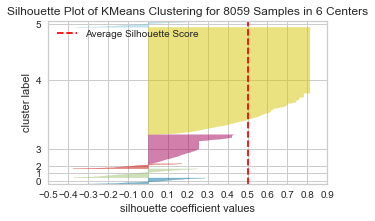

0.502833469689105

In [50]:
silhouette_visualizer(KMeans(6, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

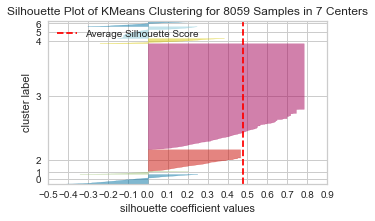

0.47932861248405473

In [51]:
silhouette_visualizer(KMeans(7, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

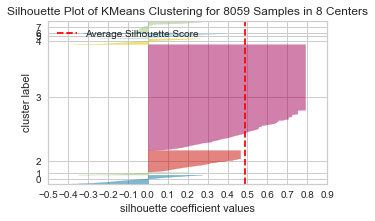

0.488544329388345

In [52]:
silhouette_visualizer(KMeans(8, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

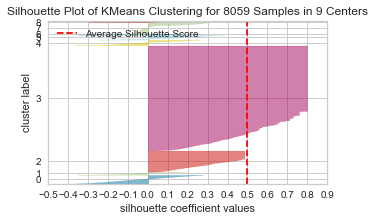

0.4954002477521856

In [53]:
silhouette_visualizer(KMeans(9, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

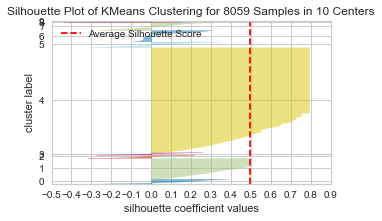

0.4968755245493548

In [54]:
silhouette_visualizer(KMeans(10, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_

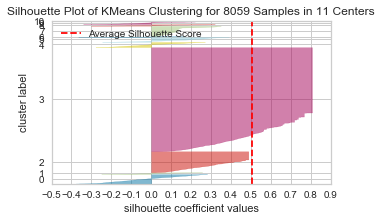

0.5063550264011099

In [55]:
silhouette_visualizer(KMeans(11, random_state=0), kbest_total_abs, colors='yellowbrick').silhouette_score_